## Fix loss (pt 3)

The loss for the code search problem seems off. We train to convergence but still see poor performance. So let's take a close look at the meaning of our loss functions.

In [1]:

import numpy as np

import tensorflow as tf

from tensor2tensor.data_generators import problem
from tensor2tensor.layers import common_layers
from tensor2tensor.models import transformer
from tensor2tensor.utils import registry
from tensor2tensor.utils import t2t_model
from tensor2tensor.models.transformer import Transformer

from tensor2tensor.models.transformer import transformer_base

from tk.experiment import configure_experiment, T2TExperiment

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys


In [ ]:

# Run separately (with fresh kernel b/c currently allen_demo initializes tfe.)
from tk.allen_demo import event_data_for_comparison, show_experiment_loss
%matplotlib inline


### Losses

In [ ]:

_LOSS_VARIANTS = [
    "slicenet",
    "kfnet",
    "simple_cd"
]


def _cosine_similarity(a, b):
  """Computes the cosine similarity between two tensors."""

  with tf.name_scope("cosine_similarity"):

    a = tf.nn.l2_normalize(a, 1)
    b = tf.nn.l2_normalize(b, 1)
    return tf.matmul(a, b, transpose_b=True)


def slicenet_similarity_cost(a, b, margin=0.2):
  """Hinge cosine similarity poached from slicenet.
  
  TODO: Not clear on cost_im or why we're clearing the diagonals.

  """

  with tf.name_scope("slicenet_loss"):

    a, b = common_layers.pad_to_same_length(a, b)

    cosine_similarity = _cosine_similarity(a, b)

    diagonal = tf.diag_part(cosine_similarity)
    cost_s = tf.maximum(0.0, margin - diagonal + cosine_similarity)
    cost_im = tf.maximum(
        0.0, margin - tf.reshape(diagonal, [-1, 1]) + cosine_similarity)

    # Clear diagonals.
    batch_size = tf.shape(a)[0]
    empty_diagonal_mat = tf.ones_like(cost_s) - tf.eye(batch_size)
    cost_s *= empty_diagonal_mat
    cost_im *= empty_diagonal_mat

    return tf.reduce_mean(cost_s) + tf.reduce_mean(cost_im)


def simple_similarity_cost(a, b, k=2):
  """Experimental simplified cosine distance loss.
  
  TODO: Consider making k a function of batch size to control weighting of
  importance of self- vs non-self distances.
  
  """

  with tf.name_scope("simple_cd_loss"):

    cosine_similarity = _cosine_similarity(a, b)

    # get scores that refer to two embeddings that should correspond
    self_cosine_similarity = tf.diag_part(cosine_similarity)
    
    # Sum the values off the diagonal with 1 - values on diagonal, k >=0, maybe 2
    # Will have values on range [-B^2, B^2] for batch size B.
    return tf.reduce_mean(cosine_similarity) - k*tf.reduce_mean(self_cosine_similarity)


def kubeflow_similarity_cost(a, b, scale_factor=20, target=0):
  """Modification to original kubeflow code_search example loss.

  Notes:
  - Use cosine similarity instead of cosine distance.
  - Allow specification of stretch factor.

  TODO: Consider adding a shift factor that is a function of the query distance
  and the stretch factor.

  Args:
    a (tensor): An embedding vector.
    b (tensor): An embedding vector.
    scale_factor (float): Scale c.d. from [-1,1] to [-sf,sf].

  """

  with tf.name_scope("kf_loss"):
        
    shift = scale_factor*(1 - target)

    cosine_similarity = _cosine_similarity(a, b)
    cosine_similarity_flat = tf.reshape(cosine_similarity, [-1, 1])
    cosine_similarity_flat = scale_factor * cosine_similarity_flat - shift

    # Positive samples on the diagonal, reshaped as row-major.
    label_matrix = tf.eye(tf.shape(cosine_similarity)[0], dtype=tf.float32)
    label_matrix_flat = tf.reshape(label_matrix, [-1, 1])

    return tf.nn.sigmoid_cross_entropy_with_logits(labels=label_matrix_flat,
                                                   logits=cosine_similarity_flat)


### "kf" cost

In [22]:

a = tf.convert_to_tensor(np.array([[1.0,0.01],[0.01,1.0]], dtype=np.float32))
b = tf.convert_to_tensor(np.array([[0.01,1.0],[1.0,0.01]], dtype=np.float32))
b2 = tf.convert_to_tensor(np.array([[0.9,0.1],[0.1,0.9]], dtype=np.float32))
b3 = tf.convert_to_tensor(np.array([[1.0,0.01],[0.01,1.0]], dtype=np.float32))


In [27]:

print(tf.reduce_mean(kubeflow_similarity_cost(a, b, target=0.0)))
print(tf.reduce_mean(kubeflow_similarity_cost(a, b2, target=0.0)))
print(tf.reduce_mean(kubeflow_similarity_cost(a, b3, target=0.0)))


tf.Tensor(10.146594, shape=(), dtype=float32)
tf.Tensor(0.37252244, shape=(), dtype=float32)
tf.Tensor(0.3465731, shape=(), dtype=float32)


In [28]:
# Here we used a target of 0 and we can see the loss doesn't change significantly when embedding vectors are near their targets.

In [29]:

print(tf.reduce_mean(kubeflow_similarity_cost(a, b, target=0.2)))
print(tf.reduce_mean(kubeflow_similarity_cost(a, b2, target=0.2)))
print(tf.reduce_mean(kubeflow_similarity_cost(a, b3, target=0.2)))


tf.Tensor(9.809096, shape=(), dtype=float32)
tf.Tensor(0.010032762, shape=(), dtype=float32)
tf.Tensor(0.009075031, shape=(), dtype=float32)


In [32]:
# Hmm so in this latter case where our solutions are near perfect the loss is closer to zero than in the first case.
# I would wonder whether there are solutions to the first case that are more optimal than these that get closer to zero.
# Would like to visualize the surface of solutions holding one embedding category fixed.

In [33]:
# Close to target but also to eachothers

a = tf.convert_to_tensor(np.array([[1.0,0.01],[1.0,0.01]], dtype=np.float32))
b = tf.convert_to_tensor(np.array([[1.0,0.01],[1.0,0.01]], dtype=np.float32))
print(tf.reduce_mean(kubeflow_similarity_cost(a, b, target=0.0)))
print(tf.reduce_mean(kubeflow_similarity_cost(a, b, target=0.2)))


tf.Tensor(0.6931472, shape=(), dtype=float32)
tf.Tensor(2.0181508, shape=(), dtype=float32)


In [ ]:
# Thus with target =0.2 we seem to assign a higher relative cost to similarity with other embeddings.

In [ ]:
a = tf.convert_to_tensor(np.array([[1.0,0.01],[1.0,0.01]], dtype=np.float32))
b = tf.convert_to_tensor(np.array([[1.0,0.01],[1.0,0.01]], dtype=np.float32))
print(tf.reduce_mean(kubeflow_similarity_cost(a, b, target=0.0)))
print(tf.reduce_mean(kubeflow_similarity_cost(a, b, target=0.2)))

In [34]:

import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline


In [102]:

def compute_costs(target=0.0, sf=20):
    a = tf.convert_to_tensor(np.array([[1.0,0.01],[0.01,1.0]], dtype=np.float32))

    costs = np.zeros((100,100))
    for i in range(1,100):

        for j in range(1,100):

            b = tf.convert_to_tensor(np.array([[1.0,i/100.0],[j/100.0,1.0]], dtype=np.float32))
            c = tf.reduce_mean(kubeflow_similarity_cost(a, b, target=target, scale_factor=sf))
            costs[i][j] = c.numpy()
        
    return costs


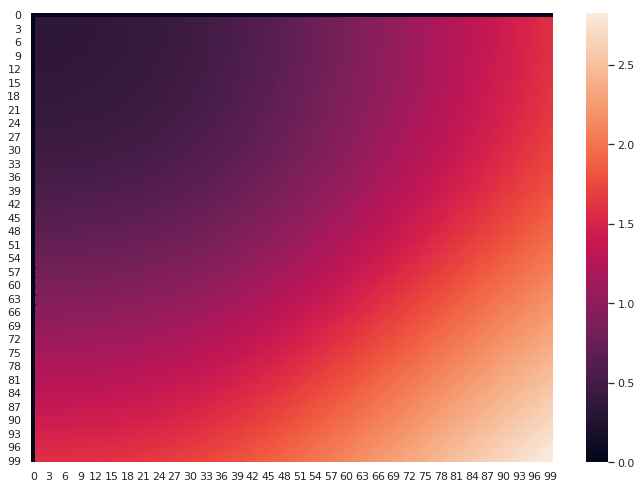

In [82]:

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(compute_costs())


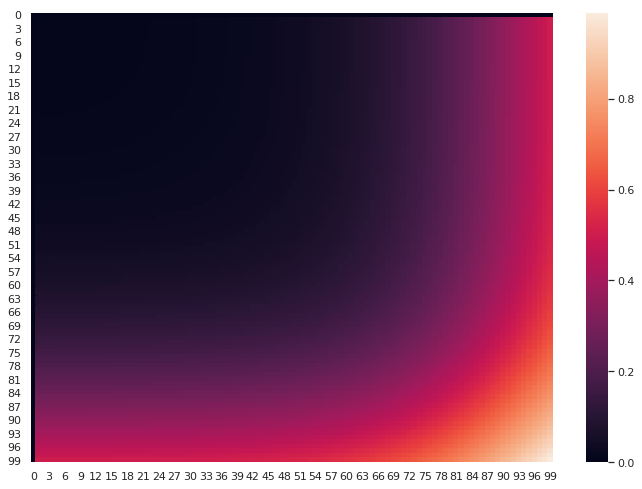

In [83]:

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(compute_costs(0.2))


In [ ]:
# This second case might be easier to optimize given how steep it makes the region right outside a distance of 0.2.

In [85]:
from tk.models.similarity_transformer import _cosine_similarity

In [96]:
_cosine_similarity(tf.convert_to_tensor([[1.0,0.0]]), tf.convert_to_tensor([[1.0,70/100.0]]))

<tf.Tensor: id=5373288, shape=(1, 1), dtype=float32, numpy=array([[0.8192319]], dtype=float32)>

Yeah so in the second plot we see the space of optimization is primarily beyond distances of 0.2 whereas in the first we see optimization more evenly spread over all distances. I'm not sure it's important to pursue the latter.

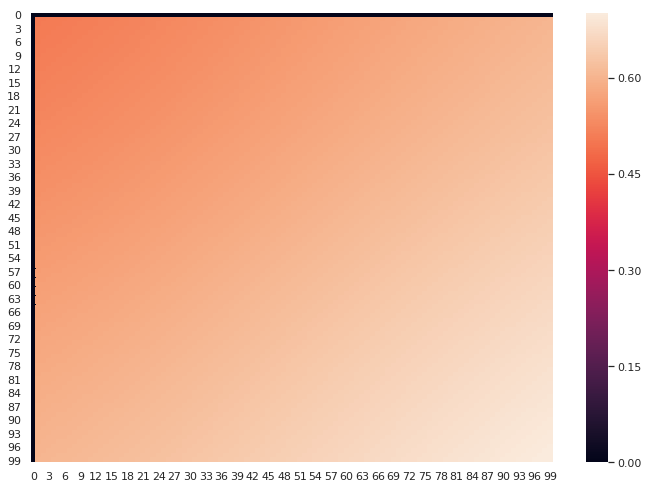

In [103]:

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(compute_costs(sf=1))

# Here when the scale factor is 1.0 we don't do a good job of spanning the range of possible distances


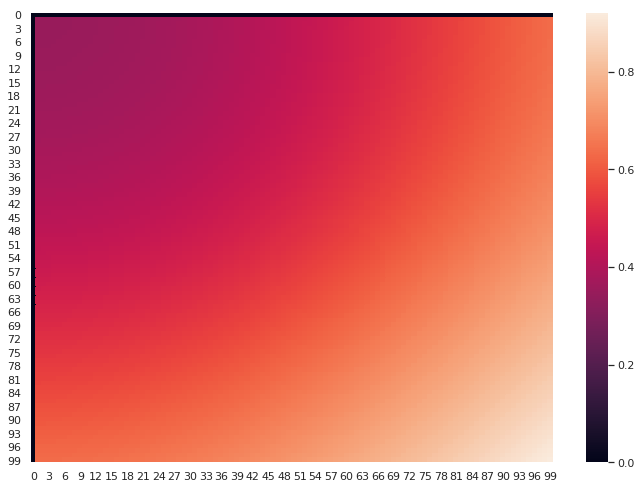

In [104]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(compute_costs(sf=5))

In [107]:

def compute_costsv2(target=0.0, sf=20):
    a = tf.convert_to_tensor(np.array([[1.0,0.01],[0.01,1.0]], dtype=np.float32))

    costs = np.zeros((100,100))
    for i in range(1,100):

        for j in range(1,100):

            b = tf.convert_to_tensor(np.array([[1.0,0.01],[i/100.0,j/100.0]], dtype=np.float32))
            c = tf.reduce_mean(kubeflow_similarity_cost(a, b, target=target, scale_factor=sf))
            costs[i][j] = c.numpy()
        
    return costs


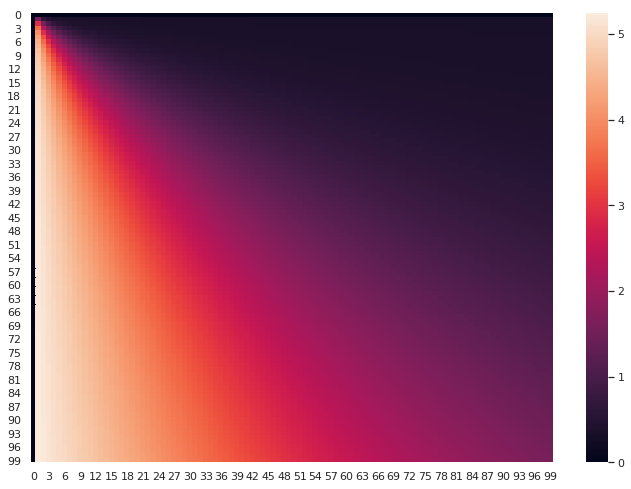

In [108]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(compute_costsv2())

# Here the first vector in the pair is correct and the second varies from 

### Re-training

In [97]:

from tk.experiment import configure_experiment, T2TExperiment


In [101]:

args = configure_experiment("cs-kf-1",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                                 "loss_variant": "kfnet"
                             },
                             num_gpu_per_worker=1,
                             num_steps=5000,
                             num_ps=0,
                             schedule="train")

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'loss_variant=kfnet'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-kf-1/cs-kf-1-j1022-2108-b753/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-kf-1/cs-kf-1-j1022-2108-b753/tk',
 'train_steps': 5000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


In [ ]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr*")
show_experiment_loss(experiment_data)

In [109]:

args = configure_experiment("cs-kf-sf20-targ02",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                                 "loss_variant": "kfnet"
                             },
                             num_gpu_per_worker=1,
                             num_steps=5000,
                             num_ps=0,
                             schedule="train")

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'loss_variant=kfnet'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ02/cs-kf-sf20-targ02-j1022-2118-de9f/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ02/cs-kf-sf20-targ02-j1022-2118-de9f/tk',
 'train_steps': 5000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


In [126]:

args = configure_experiment("cs-kf-sf20-targ0-lr",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                                 "loss_variant": "kfnet"
                             },
                             num_gpu_per_worker=1,
                             num_steps=50000,
                             num_ps=0,
                             schedule="train")

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'loss_variant=kfnet'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ0-lr/cs-kf-sf20-targ0-lr-j1022-2124-352a/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ0-lr/cs-kf-sf20-targ0-lr-j1022-2124-352a/tk',
 'train_steps': 50000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


In [127]:

args = configure_experiment("cs-kf-sf20-targ02-lr",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                                 "loss_variant": "kfnet"
                             },
                             num_gpu_per_worker=1,
                             num_steps=50000,
                             num_ps=0,
                             schedule="train")

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'loss_variant=kfnet'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ02-lr/cs-kf-sf20-targ02-lr-j1022-2124-89f0/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ02-lr/cs-kf-sf20-targ02-lr-j1022-2124-89f0/tk',
 'train_steps': 50000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-22 22:04:55,978] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 4)


[2018-10-22 22:04:57,209] Processing experiment events (1 of 4)


INFO:tensorflow:Processing experiment events (2 of 4)


[2018-10-22 22:04:58,422] Processing experiment events (2 of 4)


INFO:tensorflow:Processing experiment events (3 of 4)


[2018-10-22 22:04:59,907] Processing experiment events (3 of 4)


INFO:tensorflow:Processing experiment events (4 of 4)


[2018-10-22 22:05:01,499] Processing experiment events (4 of 4)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-22 22:05:02,862] Finished loading event data for comparison.


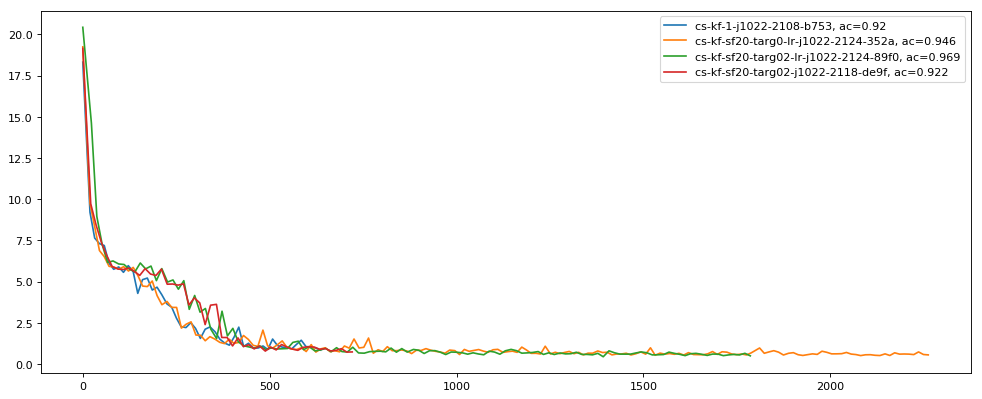

In [4]:

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-kf*")
show_experiment_loss(experiment_data)


### Simple cosine distance

In [110]:
from tk.models.similarity_transformer import simple_similarity_cost

In [124]:

a = tf.convert_to_tensor(np.array([[1.0,0.01],[1.0,0.01]], dtype=np.float32))
b = tf.convert_to_tensor(np.array([[1.0,0.01],[0.01,1.0]], dtype=np.float32))
simple_similarity_cost(a,b) + 1


<tf.Tensor: id=7020131, shape=(), dtype=float32, numpy=0.49000096>

In [125]:
_cosine_similarity(a, b)

<tf.Tensor: id=7020143, shape=(2, 2), dtype=float32, numpy=
array([[1.0000001, 0.019998 ],
       [1.0000001, 0.019998 ]], dtype=float32)>

In [132]:

def compute_costsv2(target=0.0, sf=20):
    a = tf.convert_to_tensor(np.array([[1.0,0.01],[0.01,1.0]], dtype=np.float32))

    costs = np.zeros((100,100))
    for i in range(0,100):

        for j in range(0,100):

            b = tf.convert_to_tensor(np.array([[1.0,i/100.0],[j/100.0,1.0]], dtype=np.float32))
            c = tf.reduce_mean(simple_similarity_cost(a, b) + 1)
            costs[i][j] = c.numpy()
        
    return costs


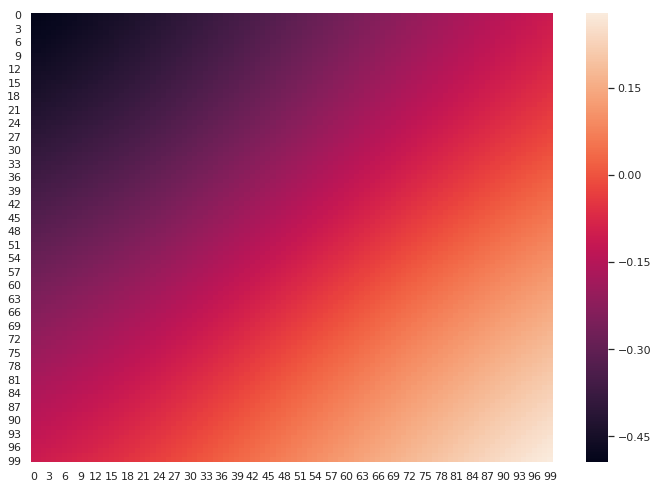

In [133]:

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(compute_costsv2())


In [ ]:
# So this cost separates out the self and non-self associations, of which the latter there are exponentially more.
# Such a correction is not made in the kf loss and it's not clear to me how you would do that.

In [134]:

args = configure_experiment("cs-cd-k2-lr",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                                 "loss_variant": "simple_cd"
                             },
                             num_gpu_per_worker=1,
                             num_steps=50000,
                             num_ps=0,
                             schedule="train")

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'loss_variant=simple_cd'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-cd-k2-lr/cs-cd-k2-lr-j1022-2133-64df/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-cd-k2-lr/cs-cd-k2-lr-j1022-2133-64df/tk',
 'train_steps': 50000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-22 22:04:08,512] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-22 22:04:08,645] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-22 22:04:10,331] Finished loading event data for comparison.


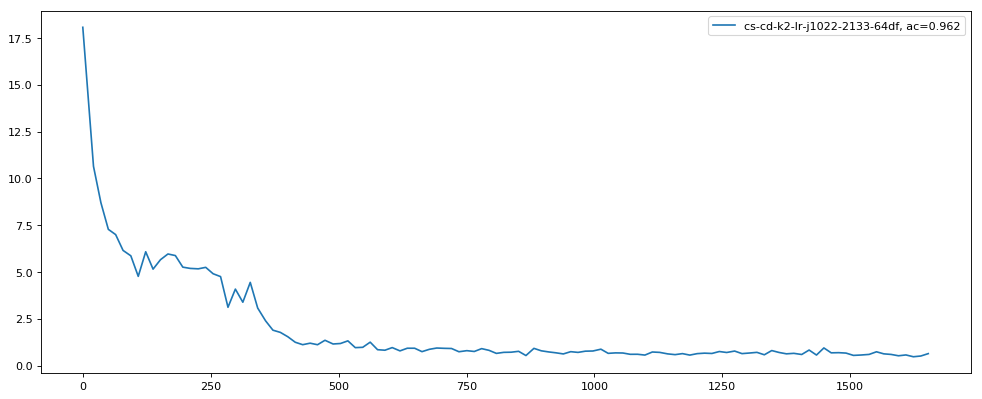

In [2]:

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-cd-k2-lr")
show_experiment_loss(experiment_data)


### Slicenet cost

In [135]:
from tk.models.similarity_transformer import slicenet_similarity_cost

In [136]:

a = tf.convert_to_tensor(np.array([[1.0,0.01],[1.0,0.01]], dtype=np.float32))
b = tf.convert_to_tensor(np.array([[1.0,0.01],[0.01,1.0]], dtype=np.float32))
slicenet_similarity_cost()

<tf.Tensor: id=7691239, shape=(), dtype=float32, numpy=0.39500052>

In [137]:

def compute_costsv2(target=0.0, sf=20):
    a = tf.convert_to_tensor(np.array([[1.0,0.01],[0.01,1.0]], dtype=np.float32))

    costs = np.zeros((100,100))
    for i in range(0,100):

        for j in range(0,100):

            b = tf.convert_to_tensor(np.array([[1.0,i/100.0],[j/100.0,1.0]], dtype=np.float32))
            c = tf.reduce_mean(slicenet_similarity_cost(a, b) + 1)
            costs[i][j] = c.numpy()
        
    return costs


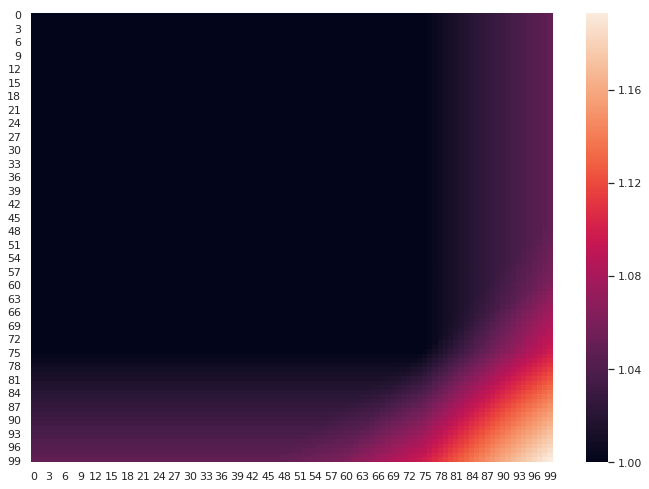

In [138]:

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(compute_costsv2())


In [ ]:
# The slicenet loss seems to have a similar profile to the target=0.2 version of kfnet but it's even more abrupt
# outside a CD of ~0.2.

In [170]:
# I don't currently understand this code:

a = tf.convert_to_tensor(np.array([[1.0,0.01],[0.01,1.0]], dtype=np.float32))
b = tf.convert_to_tensor(np.array([[0.5,0.01],[0.01,0.5]], dtype=np.float32))

margin = 0.2

cosine_similarity = _cosine_similarity(a, b)

diagonal = tf.diag_part(cosine_similarity)
cost_s = tf.maximum(0.0, margin - diagonal + cosine_similarity)
cost_im = tf.maximum(
    0.0, margin - tf.reshape(diagonal, [-1, 1]) + cosine_similarity)


### Qualitative

In [1]:

import numpy as np

import tensorflow as tf

from tensor2tensor.data_generators import problem
from tensor2tensor.layers import common_layers
from tensor2tensor.models import transformer
from tensor2tensor.utils import registry
from tensor2tensor.utils import t2t_model
from tensor2tensor.models.transformer import Transformer

from tensor2tensor.models.transformer import transformer_base

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys


from tk.models import similarity_transformer
from tk.data_generators import function_docstring

import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:

mp_constrained_embedding = function_docstring.GithubConstrainedEmbedding()

data_dir = "/mnt/nfs-east1-d/data"

hparams = similarity_transformer.similarity_transformer_tiny()
hparams.data_dir = data_dir

p_hparams = mp_constrained_embedding.get_hparams(hparams)

model = similarity_transformer.ConstrainedEmbeddingTransformer(
    hparams, tf.estimator.ModeKeys.PREDICT, p_hparams
)

# Get the encoders from the problem
encoders = mp_constrained_embedding.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers):
  """List of ints to str
  
  For decoding an integer encoding to its string representation,
  not for decoding an embedding vector into the same.
  """
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders["inputs"].decode(np.squeeze(integers))

batch_size = 1
train_dataset = mp_constrained_embedding.dataset(Modes.PREDICT, data_dir)
train_dataset = train_dataset.repeat(None).batch(batch_size)

iterator = tfe.Iterator(train_dataset)


INFO:tensorflow:Setting T2TModel mode to 'infer'


[2018-10-29 17:50:09,093] Setting T2TModel mode to 'infer'


INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0


[2018-10-29 17:50:09,096] Setting hparams.layer_prepostprocess_dropout to 0.0


INFO:tensorflow:Setting hparams.symbol_dropout to 0.0


[2018-10-29 17:50:09,099] Setting hparams.symbol_dropout to 0.0


INFO:tensorflow:Setting hparams.attention_dropout to 0.0


[2018-10-29 17:50:09,102] Setting hparams.attention_dropout to 0.0


INFO:tensorflow:Setting hparams.dropout to 0.0


[2018-10-29 17:50:09,104] Setting hparams.dropout to 0.0


INFO:tensorflow:Setting hparams.relu_dropout to 0.0


[2018-10-29 17:50:09,107] Setting hparams.relu_dropout to 0.0


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-dev*


[2018-10-29 17:50:09,175] Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-dev*


INFO:tensorflow:partition: 0 num_data_files: 1


[2018-10-29 17:50:09,181] partition: 0 num_data_files: 1


In [3]:

def build_heatmap(dataset_iterator, model, ckpt_path):
    embeddings = []
    num_examples = 100

    with tfe.restore_variables_on_create(ckpt_path):

      for i in range(0, num_examples):
        example = dataset_iterator.next()

        doc_emb, _ = model({"inputs": example["docstring"]})
        code_emb, _ = model({"inputs": example["code"]})

        embeddings.append([doc_emb, code_emb, decode(example["docstring"]), decode(example["code"])])

    distances = np.zeros((num_examples, num_examples))

    for i in range(0, num_examples):
      for j in range(0, num_examples):
        distances[i][j] = similarity_transformer._cosine_similarity(embeddings[i][0], embeddings[j][1])
    
    return distances, embeddings


#### kfnet

INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-23 18:14:38,858] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 4)


[2018-10-23 18:14:40,174] Processing experiment events (1 of 4)


INFO:tensorflow:Processing experiment events (2 of 4)


[2018-10-23 18:14:41,461] Processing experiment events (2 of 4)


INFO:tensorflow:Processing experiment events (3 of 4)


[2018-10-23 18:14:43,677] Processing experiment events (3 of 4)


INFO:tensorflow:Processing experiment events (4 of 4)


[2018-10-23 18:14:47,903] Processing experiment events (4 of 4)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-23 18:14:49,135] Finished loading event data for comparison.


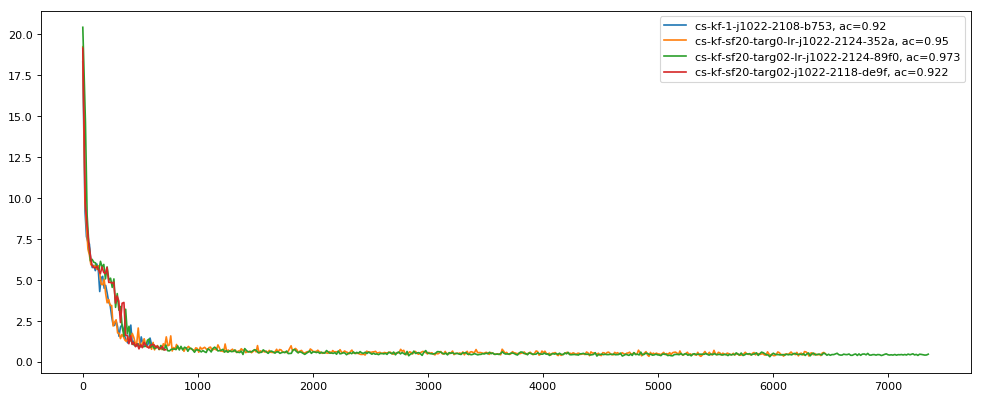

In [2]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-kf*")
show_experiment_loss(experiment_data)

##### 13931, target=0

In [4]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ0-lr/cs-kf-sf20-targ0-lr-j1022-2124-352a/output/model.ckpt-13931"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-23 18:38:57,490] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Building model body


[2018-10-23 18:38:57,531] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-23 18:38:57,604] Skipping T2TModel top and loss because training loss returned from body


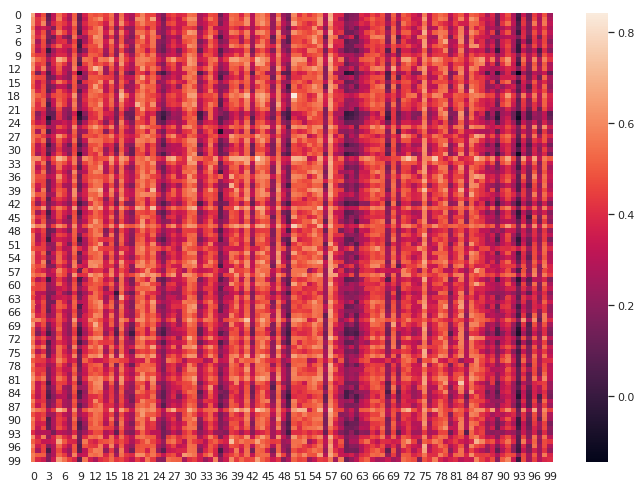

In [5]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [6]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.17024429833963514

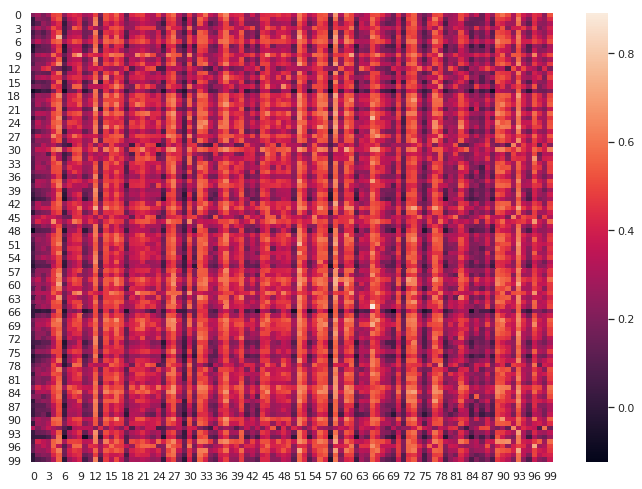

In [7]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [8]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.18624488662416117

##### 50k, target=0

In [4]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ0-lr/cs-kf-sf20-targ0-lr-j1022-2124-352a/output/model.ckpt-50000"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-23 18:39:39,030] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Building model body


[2018-10-23 18:39:39,069] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-23 18:39:39,143] Skipping T2TModel top and loss because training loss returned from body


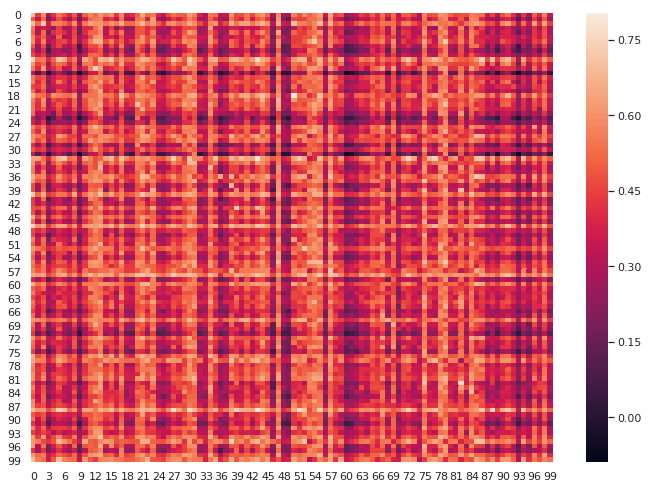

In [5]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [6]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.16422772804312408

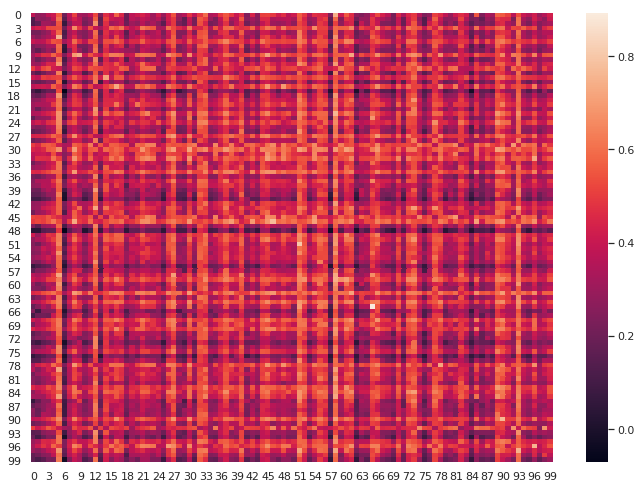

In [7]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [8]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.15790802997443826

##### 12234, taget=0.2

In [4]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ02-lr/cs-kf-sf20-targ02-lr-j1022-2124-89f0/output/model.ckpt-12234"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-23 18:40:43,857] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Building model body


[2018-10-23 18:40:43,895] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-23 18:40:43,965] Skipping T2TModel top and loss because training loss returned from body


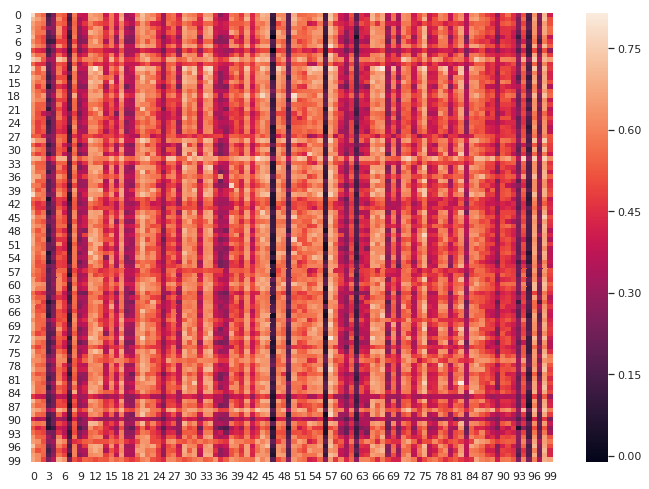

In [5]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [6]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.1745156804215163

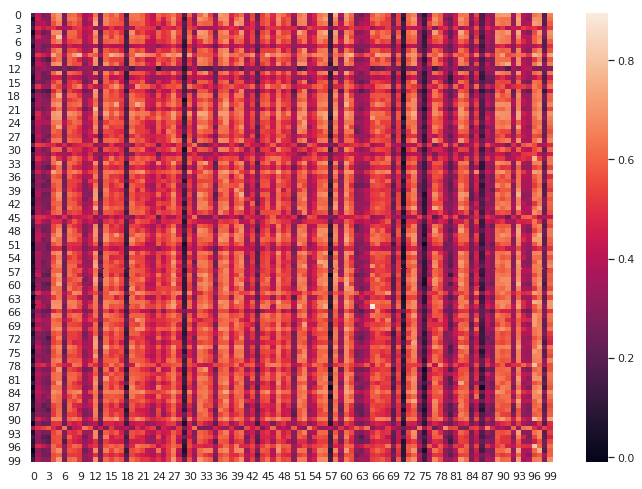

In [7]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [8]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.18673986038137227

##### 50k, target=0.2

In [4]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ02-lr/cs-kf-sf20-targ02-lr-j1022-2124-89f0/output/model.ckpt-50000"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-23 18:41:33,205] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Building model body


[2018-10-23 18:41:33,242] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-23 18:41:33,308] Skipping T2TModel top and loss because training loss returned from body


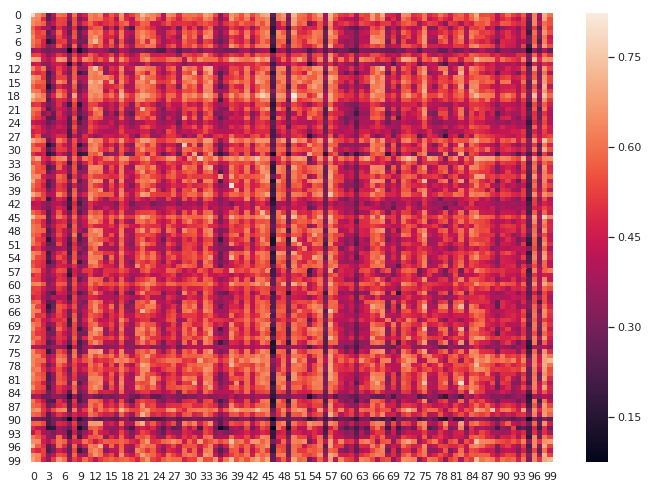

In [5]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [6]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.13706594970226288

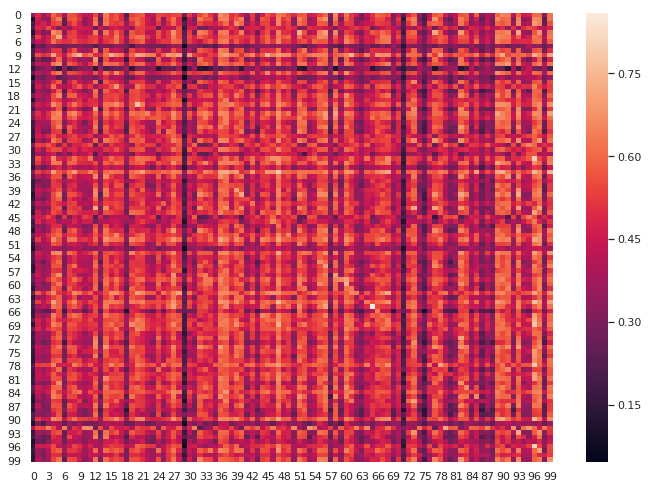

In [7]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [8]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.14463476344570517

#### simple cd

INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-10-23 18:14:52,401] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-10-23 18:14:57,516] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-10-23 18:15:01,512] Finished loading event data for comparison.


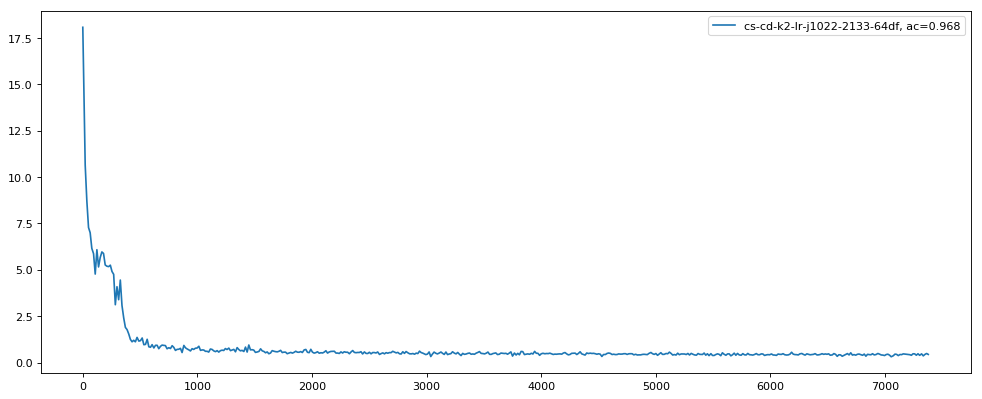

In [3]:
experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-cd-k2-lr")
show_experiment_loss(experiment_data)

##### 12261

In [4]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-cd-k2-lr/cs-cd-k2-lr-j1022-2133-64df/output/model.ckpt-12261"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-23 18:42:18,460] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Building model body


[2018-10-23 18:42:18,506] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-23 18:42:18,596] Skipping T2TModel top and loss because training loss returned from body


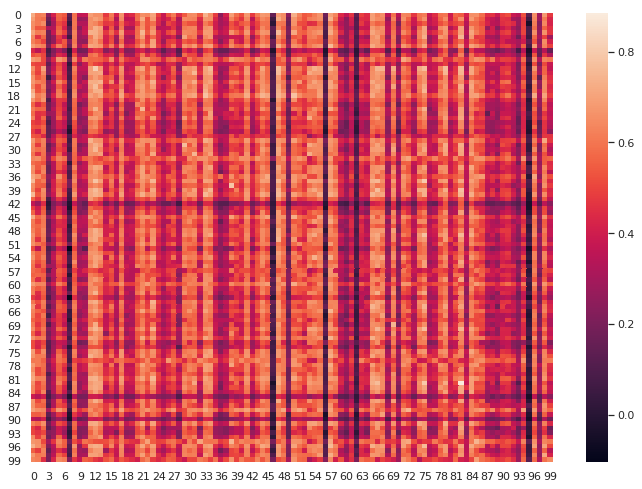

In [5]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [6]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.19593024753220378

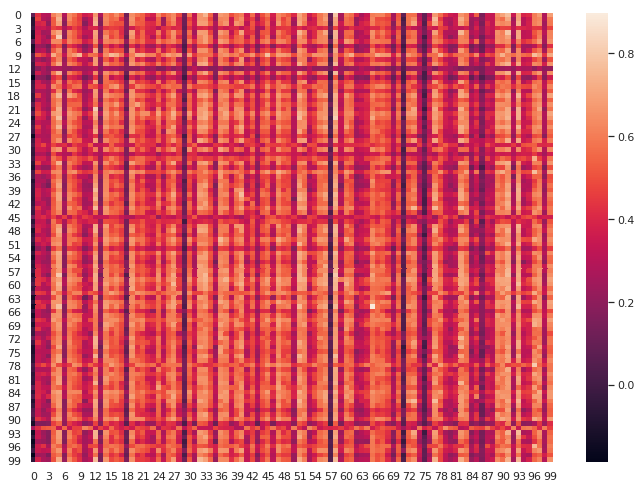

In [7]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [8]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.2064457849614322

##### 50k

In [4]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-cd-k2-lr/cs-cd-k2-lr-j1022-2133-64df/output/model.ckpt-50000"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-23 18:43:08,177] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Building model body


[2018-10-23 18:43:08,217] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-23 18:43:08,299] Skipping T2TModel top and loss because training loss returned from body


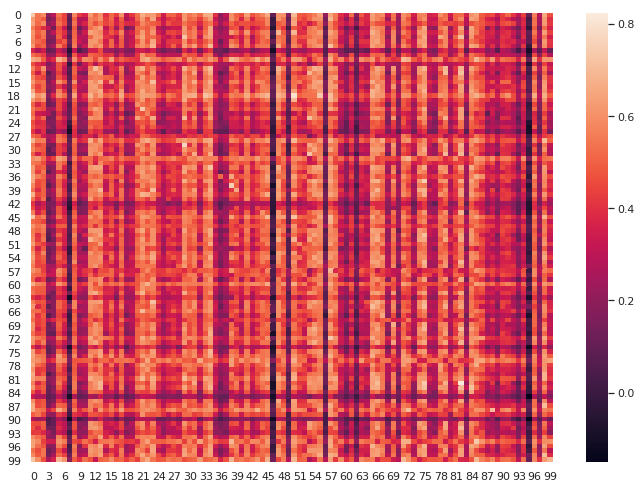

In [5]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [6]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.19270721035683527

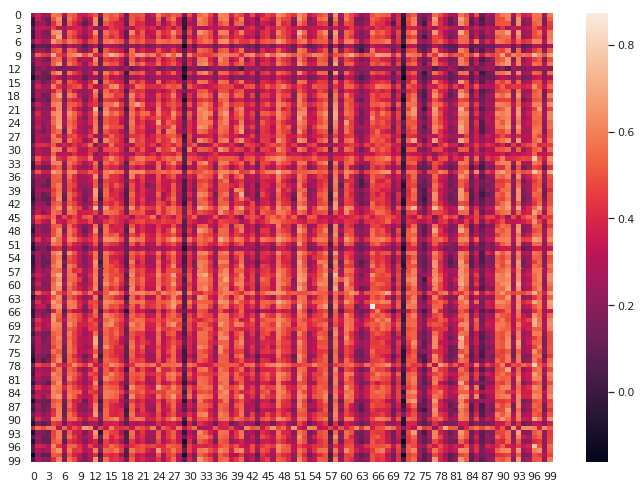

In [7]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [8]:

np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)


0.20101155527159573

### Slicenet loss

In [4]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-dist-tr-morex/cs-dist-tr-morex-j1017-1758-a24a/output/model.ckpt-5000"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-23 18:45:44,506] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Building model body


[2018-10-23 18:45:44,549] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-23 18:45:44,624] Skipping T2TModel top and loss because training loss returned from body


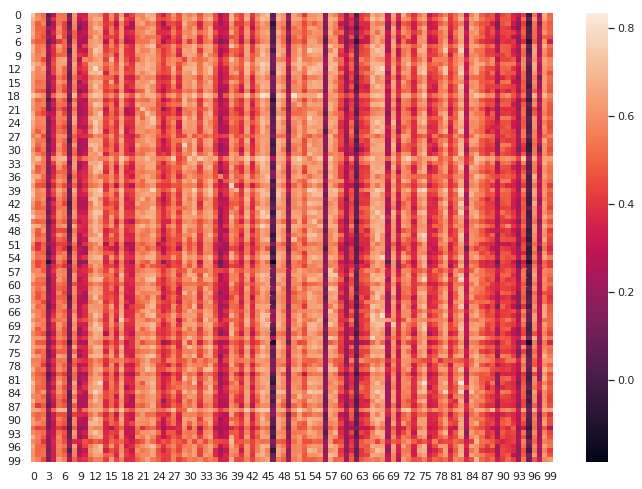

In [5]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [6]:
np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)

0.17668806032072754

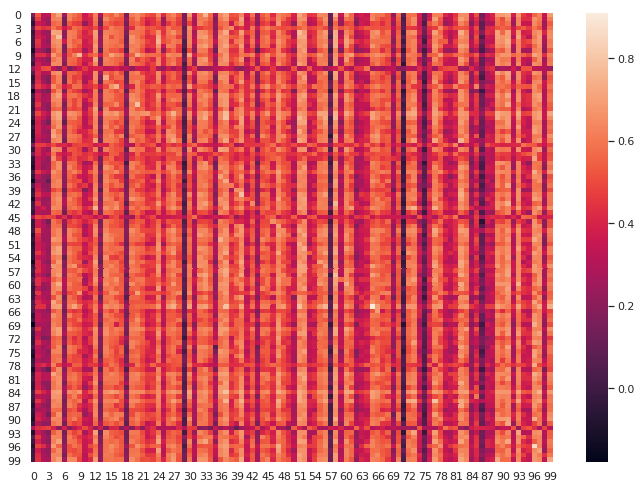

In [7]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [8]:
np.sum(np.abs(distances-np.transpose(distances)))/(np.shape(distances)[0]**2)

0.19605526341348886

### Discussion

* The ideal is to have a diagonal of all 1's and a transpose discordance of zero. We don't need to optimize for off-diagonal values to be zero.
* See a diagonal in all, would like to go back and calculate the ratio of the diagonal to the rest
  * Loss could be (non-diag)/(diag+epsilon) + tc or mean(non-diag) - mean(diag) - tc + 2
* In the above the kfnet loss with target=0.2 at 50k had the lowest td but n=2
* The idea with the transpose discordance measure is to say we don't just want self-similarity to be high and low similarity to everything else - we want the way a piece of code is positioned relative to everything else in a similar way to its docstring.

### In-painting inference

In [2]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-kf-sf20-targ02-lr/cs-kf-sf20-targ02-lr-j1022-2124-89f0/output/model.ckpt-50000"

In [3]:

mp_constrained_embedding = function_docstring.GithubConstrainedEmbedding()

data_dir = "/mnt/nfs-east1-d/data"

hparams = similarity_transformer.similarity_transformer_tiny()
hparams.data_dir = data_dir

p_hparams = mp_constrained_embedding.get_hparams(hparams)

model = similarity_transformer.ConstrainedEmbeddingTransformer(
    hparams, tf.estimator.ModeKeys.TRAIN, p_hparams
)

# Get the encoders from the problem
encoders = mp_constrained_embedding.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers):
  """List of ints to str
  
  For decoding an integer encoding to its string representation,
  not for decoding an embedding vector into the same.
  """
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders["inputs"].decode(np.squeeze(integers))

batch_size = 1
train_dataset = mp_constrained_embedding.dataset(Modes.PREDICT, data_dir)
train_dataset = train_dataset.repeat(None).batch(batch_size)

iterator = tfe.Iterator(train_dataset)


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-10-23 20:29:59,940] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-dev*


[2018-10-23 20:30:00,011] Reading data files from /mnt/nfs-east1-d/data/github_function_docstring-dev*


INFO:tensorflow:partition: 0 num_data_files: 1


[2018-10-23 20:30:00,019] partition: 0 num_data_files: 1


In [4]:
example = iterator.next()
example

{'code': <tf.Tensor: id=64, shape=(1, 33), dtype=int64, numpy=
 array([[   7,   20,    2, 6398,  609,  201,    7,  889,    3,  103,    6,
           26,  103, 6927, 1974,  132,    9,   20,  857, 2774,  262,   87,
         6398,  609,   65,  103,    9,  201,    3,  103,    9,  889,    1]])>,
 'docstring': <tf.Tensor: id=65, shape=(1, 22), dtype=int64, numpy=
 array([[  91,  152, 1145, 3876, 4026,    8,  152,   49, 7600,  283, 6882,
          281,    6,    8,    8,  123,   20,   26, 6398,  609,   18,    1]])>,
 'embed_code': <tf.Tensor: id=66, shape=(1, 1), dtype=int64, numpy=array([[0]])>,
 'inputs': <tf.Tensor: id=67, shape=(1, 22), dtype=int64, numpy=
 array([[  91,    0, 1145, 3876, 4026,    8,  152,   49, 7600,  283, 6882,
          281,    6,    8,    8,  123,   20,   26, 6398,  609,   18,    0]])>,
 'targets': <tf.Tensor: id=68, shape=(1, 22), dtype=int64, numpy=
 array([[  91,  152, 1145, 3876, 4026,    8,  152,   49, 7600,  283, 6882,
          281,    6,    8,    8,  123,   20,

In [5]:
inferred, _ = model(example)

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-23 20:30:05,356] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Transforming 'targets' with symbol_modality_8234_128.targets_bottom


[2018-10-23 20:30:05,396] Transforming 'targets' with symbol_modality_8234_128.targets_bottom


INFO:tensorflow:Building model body


[2018-10-23 20:30:05,403] Building model body


INFO:tensorflow:Transforming body output with symbol_modality_8234_128.top


[2018-10-23 20:30:05,703] Transforming body output with symbol_modality_8234_128.top


In [26]:
len(inferred.numpy()[0][0][0][0])

103

In [45]:

def decode_inferred(inferred):
  return tf.argmax(tf.squeeze(inferred, [0,2,3]), axis=1)

decode_inferred(inferred)


<tf.Tensor: id=3493, shape=(22,), dtype=int64, numpy=
array([ 103,   91,  152, 1145, 3876, 4026,    8,  152,   49, 7600,  283,
       6882,  281,    6,    8,    8,  123,   20,   26, 6398,  609,   18])>

In [46]:
decode(decode_inferred(inferred))

'text this method decorator prevents the method from executing normally if the the input is not lowercase .'

In [47]:
decode(example["targets"])

'this method decorator prevents the method from executing normally if the the input is not lowercase .'

In [48]:
decode(example["inputs"])

'this<pad>decoratorprevents the method from executing normally if the the input is not lowercase .<pad>'

In [49]:
# Haha cool! So did it really just figure out that the missing word is "method" or did it memorize the training set?

In [54]:

def inpaint_code(iterator, display=True):
    example = iterator.next()
    
    inferred, _ = model(example)
    
    decoded_inference = decode(decode_inferred(inferred))
    decoded_target = decode(example["targets"])
    decoded_input = decode(example["inputs"])
    
    if display:
      print("Input: %s\n" % decoded_input)
      print("Target: %s\n" % decoded_target)
      print("Inference: %s\n" % decoded_inference)
    
    return decoded_input, decoded_target, decoded_inference


In [56]:

# Figured out the word "uncompressed"
_ = inpaint_code(iterator)


Input: process<pad>mpress<pad>warcto plain text<pad>

Target: process uncompressed warc to plain text .

Inference: remote process uncompressed warc to plain text .



In [57]:

_ = inpaint_code(iterator)


Input: returns a callable which let you create room<pad>

Target: returns a callable which let you create room attributes

Inference: metrics returns a(whichANyou create room attributes



In [58]:

_ = inpaint_code(iterator)


Input: <pad>aset of parts to the db , in a batch if possible .

Target: save a set of parts to the db , in a batch if possible .

Inference: crashsave a set of crashto the db , in a batch if possible .



In [59]:

_ = inpaint_code(iterator)


Input: end `` with `` block .

Target: end `` with `` block .

Inference: remote end `` with `` block .



In [60]:

_ = inpaint_code(iterator)


Input: initialise<pad>a<pad> ' distributionlineseg<pad> '  instance .<pad>

Target: initialises a new ' distributionlinesegment ' instance .

Inference: ysinitialises a new ' distributionlinesegment ' instance human



In [61]:

_ = inpaint_code(iterator)


Input: insert template values where possible - value is a<pad> - templ_const is a dictionary of template strings ( constants ) - templ<pad>valis an<pad>dictionaryof template strings specific for this easy<pad>file

Target: insert template values where possible - value is a string - templ_const is a dictionary of template strings ( constants ) - templ_val is an ordered dictionary of template strings specific for this easyconfig file

Inference: 120insert template values where possible phyvalue is a string - templ comparison const is a dictionary of template JSO (  constants ) - templ_val is an ordered dictionary of template strings specific for this easyconfig file



In [62]:

_ = inpaint_code(iterator)


Input: the new - style c{<pad>log_system " } key is copied to the old<pad>stylec{"system " } key .

Target: the new - style c{"log_system " } key is copied to the old - style c{"system " } key .

Inference: tes the new - style c{"log_system " ANkey is copied to the old - style home{" system " clearkey .



In [ ]:
# Ok so these are all doc strings when they were supposed to be a mixture of the two.

In [65]:
decode(iterator.next()["inputs"])

'propagation to an unregist<pad>provider with explicit<pad>urls .'

In [66]:
decode(iterator.next()["inputs"])

'returns the time series<pad><pad>thegiven attribute<pad>atime_series json document response .<pad>'

In [67]:
decode(iterator.next()["inputs"])

'closes the previously<pad>pg<pad>window<pad>'

In [82]:
np.random.randint(2) == 0

True

In [99]:
for i in range(0,10000):
  t  = decode(iterator.next()["targets"])
  if "args" in t or "Args" in t:
    if ":" in t:
      if "(" in t and ") :" in t:
        if not t.startswith("args"):
          print(t + "\n")

signal used for creating flux objects in the database ( for statistic purposes ) : param sender : : param kwargs : : return :

display text ( scrolling as needed ) args : text ( str ) : text string to display

this function finds a distinguish string between two wafs , by performing sfadiff algorithm . the rulesets do not need to be precise . args : waf_key_a ( str ) : the first waf name waf_key_b ( str ) : the second waf name selected_rule_a ( str ) : the path for the file containing the known rules of the first waf selected_rule_b ( str ) : the path for the file containing the known rules of the second waf returns : str : a distinguish string

algorithm for choosing which members of the population mate . the current best and the current worse mate . this is continued until all members of the population are done . args : population(list of chromosomes ) : all members of the ga 's population . alter(list of int ) : which chromosomes shall be kept .

internal function for repository cla

### Loss extensions

In [110]:

a = tf.convert_to_tensor(np.array([[1.0,0.01],[0.01,1.0]], dtype=np.float32))
b = tf.convert_to_tensor(np.array([[0.3,0.01],[0.01,0.7]], dtype=np.float32))

kf_loss = similarity_transformer.kubeflow_similarity_cost(a, b, target=0.1)


In [111]:
kf_loss

<tf.Tensor: id=153049, shape=(4, 1), dtype=float32, numpy=
array([[2.0723925e-09],
       [9.6516299e-01],
       [1.2172010e+00],
       [2.0615312e-09]], dtype=float32)>

In [113]:
cs = similarity_transformer._cosine_similarity(a, b)

cs


<tf.Tensor: id=153086, shape=(2, 2), dtype=float32, numpy=
array([[0.9997281 , 0.02428203],
       [0.04330711, 0.9999909 ]], dtype=float32)>

In [115]:

tf.reduce_mean(tf.abs(cs - tf.transpose(cs)))


<tf.Tensor: id=153116, shape=(), dtype=float32, numpy=0.009512543>

In [ ]:
# This loss should give more information to the optimization...

In [2]:

for loss_variant in ["kfnet", "simple_cd"]:

  for use_ts in [0, 1]:

    args = configure_experiment("cs-lcomp-lv%s-tc%s" % (loss_variant, use_ts),
                                 problem="github_constrained_embedding",
                                 hparams_set="similarity_transformer_tiny",
                                 model="constrained_embedding_transformer",
                                 extra_hparams={
                                     "loss_variant": loss_variant,
                                     "use_transpose_similarity": use_ts
                                 },
                                 num_gpu_per_worker=1,
                                 num_steps=25000,
                                 num_ps=2,
                                 schedule="train")

    job = T2TExperiment(**args)
    job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'use_transpose_similarity=0,loss_variant=kfnet'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-lcomp-lvkfnet-tc0/cs-lcomp-lvkfnet-tc0-j1024-1740-3f63/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-lcomp-lvkfnet-tc0/cs-lcomp-lvkfnet-tc0-j1024-1740-3f63/tk',
 'train_steps': 25000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}
train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'use_transpose_similarity=1,loss_variant=kfnet'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_

In [1]:

# Run separately (with fresh kernel b/c currently allen_demo initializes tfe.)
from tk.allen_demo import event_data_for_comparison, show_experiment_loss
%matplotlib inline


INFO:tensorflow:Identifying event files in experiment subdirectories...


INFO:tensorflow:Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 4)


INFO:tensorflow:Processing experiment events (1 of 4)


INFO:tensorflow:Processing experiment events (2 of 4)


INFO:tensorflow:Processing experiment events (2 of 4)


INFO:tensorflow:Processing experiment events (3 of 4)


INFO:tensorflow:Processing experiment events (3 of 4)


INFO:tensorflow:Processing experiment events (4 of 4)


INFO:tensorflow:Processing experiment events (4 of 4)


INFO:tensorflow:Finished loading event data for comparison.


INFO:tensorflow:Finished loading event data for comparison.


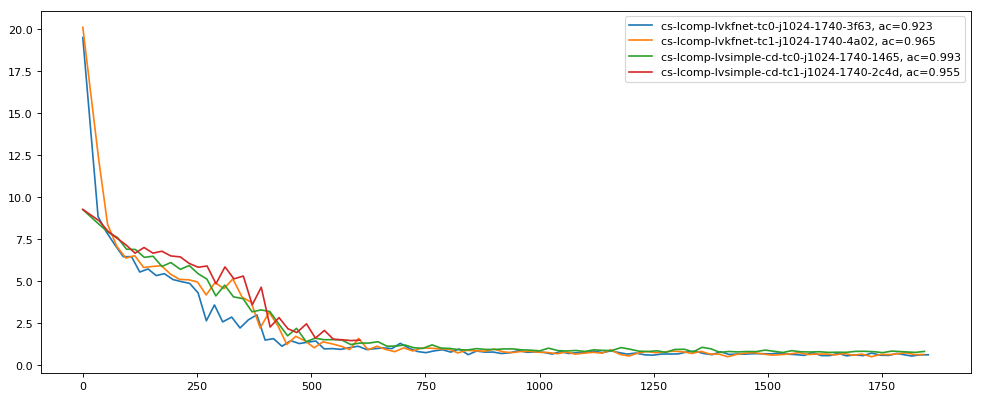

In [4]:

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-lcomp*")
show_experiment_loss(experiment_data)


#### Qualitative analysis

In [4]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-lcomp-lvkfnet-tc1/cs-lcomp-lvkfnet-tc1-j1024-1740-4a02/output/model.ckpt-8986"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom
INFO:tensorflow:Building model body
INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


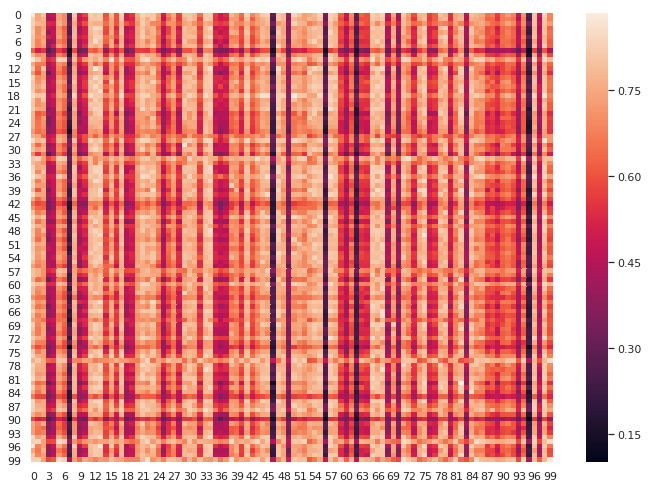

In [5]:

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)


In [7]:
np.mean(np.abs(distances - np.transpose(distances)))

0.17900741335749626

In [ ]:
# Something is fishy, checking untrained model

In [4]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-lcomp-lvkfnet-tc1/cs-lcomp-lvkfnet-tc1-j1024-1740-4a02/output/model.ckpt-0"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom
INFO:tensorflow:Building model body
INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


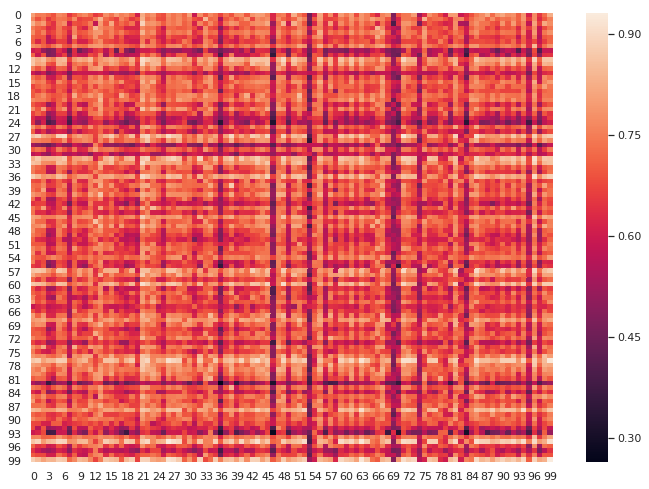

In [5]:
distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)

In [6]:

np.mean(np.abs(distances - np.transpose(distances)))

# Dude so the transpose similarity got worse during training?

0.11270962893366814

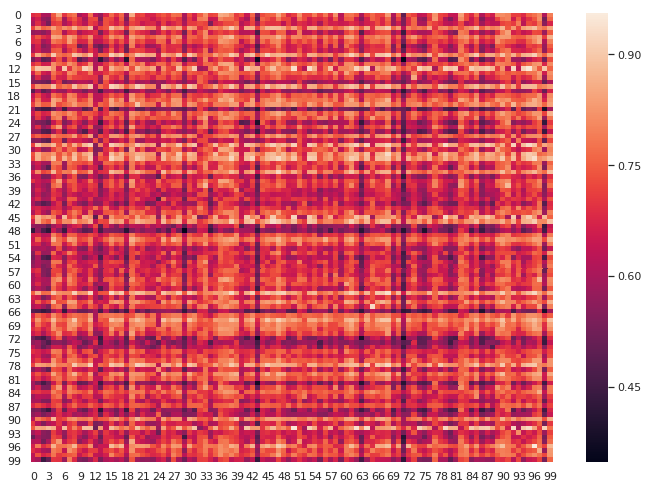

In [7]:
distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)

In [8]:
np.mean(np.abs(distances - np.transpose(distances)))


0.11631454618573189

In [ ]:
# Could certainly weight the transpose similarity to have greater importance
# This and the tboard values differ because the batch sizes are different

In [ ]:
# Looking at the parallel simple_cd and transpose_similarity loss plots there is an
# inversion in the latter with improvement in the fromer making me wonder if
# the former is not implemented correctly.

In [ ]:
# Transpose similarity should probably be computed using a second round of cosine
# similarity instead of just the difference with the transpose.
# cd(m, t(m))

In [4]:
ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-lcomp-lvkfnet-tc1/cs-lcomp-lvkfnet-tc1-j1024-1740-4a02/output/model.ckpt-8986"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom
INFO:tensorflow:Building model body
INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


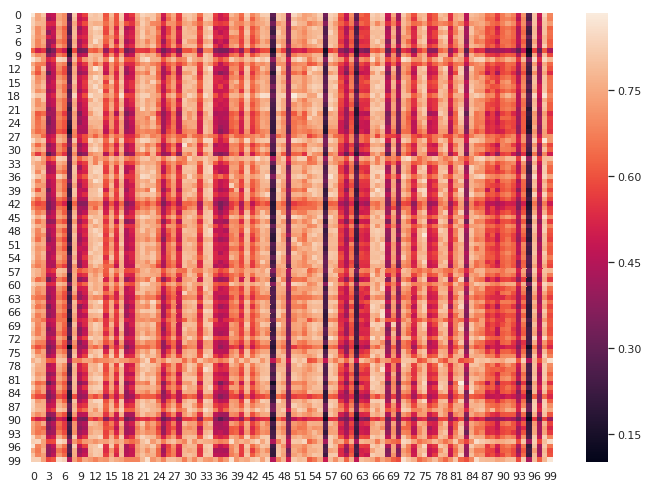

In [5]:
distances, embeddings = build_heatmap(iterator, model, ckpt_path)

m1 = []
m2 = []

for i, element in enumerate(embeddings):
  m1.append(embeddings[i][0])
  m2.append(embeddings[i][1])

t1 = tf.squeeze(tf.convert_to_tensor(m1), [1])
t2 = tf.squeeze(tf.convert_to_tensor(m2), [1])

cs = similarity_transformer._cosine_similarity(t1,t2)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(cs.numpy())


In [6]:
np.mean(np.abs(cs.numpy() - np.transpose(cs.numpy())))

0.17900741

In [7]:
cs2 = tf.reduce_mean(tf.abs(similarity_transformer._cosine_similarity(cs, tf.transpose(cs))))
cs2

<tf.Tensor: id=210661, shape=(), dtype=float32, numpy=0.9642993>

In [4]:
ckpt_path="gs://kubeflow-rl-checkpoints/comparisons/cs-lcomp-lvsimple_cd-tc0/cs-lcomp-lvsimple-cd-tc0-j1024-1740-1465/output/model.ckpt-25000"

INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom
INFO:tensorflow:Building model body
INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


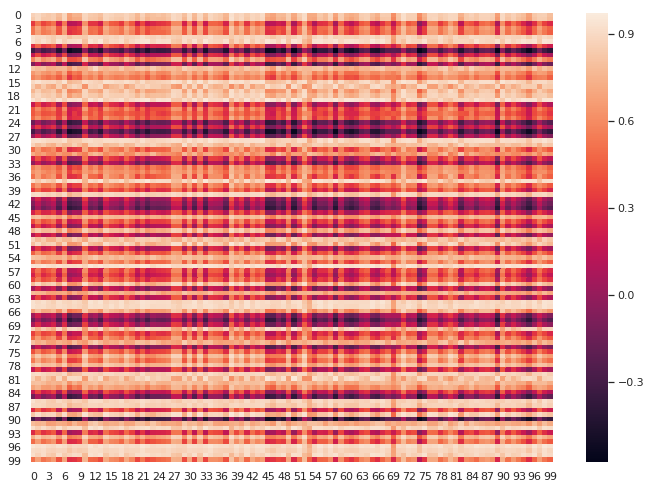

In [5]:
distances, embeddings = build_heatmap(iterator, model, ckpt_path)

m1 = []
m2 = []

for i, element in enumerate(embeddings):
  m1.append(embeddings[i][0])
  m2.append(embeddings[i][1])

t1 = tf.squeeze(tf.convert_to_tensor(m1), [1])
t2 = tf.squeeze(tf.convert_to_tensor(m2), [1])

cs = similarity_transformer._cosine_similarity(t1,t2)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(cs.numpy())


In [6]:
np.mean(np.abs(cs.numpy() - np.transpose(cs.numpy())))

# So here there's clearly not as much contrast between self and other associations as
# there is with the kfnet loss

0.38834167

In [8]:
cs2 = tf.reduce_mean(tf.abs(similarity_transformer._cosine_similarity(cs, tf.transpose(cs))))
cs2

<tf.Tensor: id=210676, shape=(), dtype=float32, numpy=0.708758>

### Additional experiments

In [6]:

args = configure_experiment("smokey-the-smoke.test",
                             problem="github_constrained_embedding",
                             hparams_set="similarity_transformer_tiny",
                             model="constrained_embedding_transformer",
                             extra_hparams={
                                 "loss_variant": "kfnet",
                                 "use_transpose_similarity": 1,
                                 "compute_mapping_loss": 1,
                                 "transpose_similarity_multiplier": 1.0,
                                 "use_transpose_cosine_similarity": 1
                             },
                             num_gpu_per_worker=1,
                             num_steps=10000,
                             num_ps=0,
                             schedule="train")

job = T2TExperiment(**args)
job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'use_transpose_similarity=1,transpose_similarity_multiplier=1.0,use_transpose_cosine_similarity=1,compute_mapping_loss=1,loss_variant=kfnet'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/smokey-the-smoke.test/smokey-the-smoke.test-j1026-0013-b522/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/smokey-the-smoke.test/smokey-the-smoke.test-j1026-0013-b522/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


In [8]:

# Maybe tf doesn't like dots in the names?

# Need to test some of these combos before launching 32 jobs.
# Also need to sanity check the named losses.

for loss_variant in ["kfnet", "simple_cd", "slicenet", "none"]:

  for use_ts in [1]:
    
    for use_t_cs in [0, 1]:

        for ts_multiplier in [1]:

            for extra_loss in [0, 1]:

                args = configure_experiment("cs-v4-lv%s-ts%s-tcs%s-tm%s-exl%s" % (
                    loss_variant, use_ts, use_t_cs, ts_multiplier, extra_loss),
                                             problem="github_constrained_embedding",
                                             hparams_set="similarity_transformer_tiny",
                                             model="constrained_embedding_transformer",
                                             extra_hparams={
                                                 "loss_variant": loss_variant,
                                                 "use_transpose_similarity": use_ts,
                                                 "compute_mapping_loss": extra_loss,
                                                 "transpose_similarity_multiplier": ts_multiplier,
                                                 "use_transpose_cosine_similarity": use_t_cs
                                             },
                                             num_gpu_per_worker=1,
                                             num_steps=10000,
                                             num_ps=0,
                                             schedule="train")

                job = T2TExperiment(**args)
                job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'use_transpose_similarity=1,transpose_similarity_multiplier=1,use_transpose_cosine_similarity=0,compute_mapping_loss=0,loss_variant=kfnet'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-v4-lvkfnet-ts1-tcs0-tm1-exl0/cs-v4-lvkfnet-ts1-tcs0-tm1-exl0-j1026-0023-dc8e/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-v4-lvkfnet-ts1-tcs0-tm1-exl0/cs-v4-lvkfnet-ts1-tcs0-tm1-exl0-j1026-0023-dc8e/tk',
 'train_steps': 10000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}
train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'use_transpose_similarity=1

### Loss experiments


* ts and tcs not sufficient on their own - can just embed everything as zeros.
* looks like kfnet exl0 tcs0 also finished early
* looks like both simple_cd exl0 failed or finished early
* possible they were just fast! simplecd should be pretty fast...
* clearly one big issue with all of these is relative weightings of different loss components.
* worth doing 25k+ steps - at 10k the learning rate has just peaked and many are continuing to make
progress
* one key reason we might not be making great progress on transpose similarity losses is their relative
weight to mapping loss which is around 0.8 at 10k steps - whereas these are around 0.08 or less.
it might be good to apply a 5-10x multiplier to at least these and perhaps the other similarity
losses...
* maybe try introducing a non-transpose similarity loss multiplier and apply the current ts_multiplier
to both ts losses.


In [11]:

for loss_variant in ["simple_cd", "slicenet"]:

  for use_ts in [1]:
    
    for use_t_cs in [1]:

        for ts_multiplier in [1, 2, 3]:

            for extra_loss in [0, 1]:
                
                for non_ts_mult in [1, 3, 5]:

                    args = configure_experiment("cs-v6-lv%s-ts%s-tcs%s-tm%s-exl%s-ntm%s" % (
                        loss_variant, use_ts, use_t_cs, ts_multiplier, extra_loss, non_ts_mult),
                                                 problem="github_constrained_embedding",
                                                 hparams_set="similarity_transformer_tiny",
                                                 model="constrained_embedding_transformer",
                                                 extra_hparams={
                                                     "loss_variant": loss_variant,
                                                     "use_transpose_similarity": use_ts,
                                                     "compute_mapping_loss": extra_loss,
                                                     "transpose_similarity_multiplier": ts_multiplier,
                                                     "use_transpose_cosine_similarity": use_t_cs
                                                 },
                                                 num_gpu_per_worker=1,
                                                 num_steps=40000,
                                                 num_ps=0,
                                                 schedule="train")

                    job = T2TExperiment(**args)
                    job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'use_transpose_similarity=1,transpose_similarity_multiplier=1,use_transpose_cosine_similarity=1,compute_mapping_loss=0,loss_variant=simple_cd'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-v6-lvsimple_cd-ts1-tcs1-tm1-exl0-ntm1/cs-v6-lvsimple-cd-ts1-tcs1-tm1-exl0-ntm1-j1026-0259-50de/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-v6-lvsimple_cd-ts1-tcs1-tm1-exl0-ntm1/cs-v6-lvsimple-cd-ts1-tcs1-tm1-exl0-ntm1-j1026-0259-50de/tk',
 'train_steps': 40000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}
train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,


In [12]:

for loss_variant in ["none"]:

  for use_ts in [1]:
    
    for use_t_cs in [1]:

        for ts_multiplier in [1, 2, 3]:

            # if no non-ts similarity loss need extra loss
            for extra_loss in [1]:
                
                for non_ts_mult in [1]:

                    args = configure_experiment("cs-v6-lv%s-ts%s-tcs%s-tm%s-exl%s-ntm%s" % (
                        loss_variant, use_ts, use_t_cs, ts_multiplier, extra_loss, non_ts_mult),
                                                 problem="github_constrained_embedding",
                                                 hparams_set="similarity_transformer_tiny",
                                                 model="constrained_embedding_transformer",
                                                 extra_hparams={
                                                     "loss_variant": loss_variant,
                                                     "use_transpose_similarity": use_ts,
                                                     "compute_mapping_loss": extra_loss,
                                                     "transpose_similarity_multiplier": ts_multiplier,
                                                     "use_transpose_cosine_similarity": use_t_cs
                                                 },
                                                 num_gpu_per_worker=1,
                                                 num_steps=40000,
                                                 num_ps=0,
                                                 schedule="train")

                    job = T2TExperiment(**args)
                    job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'use_transpose_similarity=1,transpose_similarity_multiplier=1,use_transpose_cosine_similarity=1,compute_mapping_loss=1,loss_variant=none'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-v6-lvnone-ts1-tcs1-tm1-exl1-ntm1/cs-v6-lvnone-ts1-tcs1-tm1-exl1-ntm1-j1026-0304-d80d/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-v6-lvnone-ts1-tcs1-tm1-exl1-ntm1/cs-v6-lvnone-ts1-tcs1-tm1-exl1-ntm1-j1026-0304-d80d/tk',
 'train_steps': 40000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}
train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'use_transpo


* the cs_hinge, tm3, ntm3, exl1 condition looks like it will be the most promising in regard to minimizing both the mapping loss and tm/ntm losses.
* generally the cs_hinge, exl1, tm*/ntm* conditions look to be worth pursuing further
* are checkpoints being restored correctly? it seems so.

* perhaps my current cs_unbalanced implementation is capable of succeeding in a zero condition?

* transformers and the general approach here might be helpful in scaling https://arxiv.org/pdf/1810.09717.pdf
* could just make another problem object that converts code to AST as a preprocessing step, for that would need to retain delimiters through preprocessing step

* probably want to use separate encoder networks and can learn to have good shared doc string and code embeddings by both auto-encoding and cross-mapping code- and doc-strings

* when the variance of one loss is larger than the total possible range of another we're not going to see improvement in the latter...


In [ ]:

experiment_data = event_data_for_comparison("gs://kubeflow-rl-checkpoints/comparisons/cs-v4*")
show_experiment_loss(experiment_data)


In [2]:
from tk.kube_tensorboard import TensorBoard

tb = TensorBoard(log_dir="/mnt/nfs-east1-d/ckpts",
                 namespace="kubeflow",
                 job_name_base="tb1",
                 volume_claim_id="nfs-east1-d")
tb.create()

{'api_version': 'v1',
 'kind': 'Service',
 'metadata': {'annotations': None,
              'cluster_name': None,
              'creation_timestamp': datetime.datetime(2018, 10, 26, 15, 30, 5, tzinfo=tzlocal()),
              'deletion_grace_period_seconds': None,
              'deletion_timestamp': None,
              'finalizers': None,
              'generate_name': None,
              'generation': None,
              'initializers': None,
              'labels': None,
              'name': 'tb1-svc',
              'namespace': 'kubeflow',
              'owner_references': None,
              'resource_version': '5528044',
              'self_link': '/api/v1/namespaces/kubeflow/services/tb1-svc',
              'uid': '033ef19f-d934-11e8-9b7f-42010a8e0119'},
 'spec': {'cluster_ip': '10.47.252.198',
          'external_i_ps': None,
          'external_name': None,
          'external_traffic_policy': None,
          'health_check_node_port': None,
          'load_balancer_ip': None,
 

[None, None]

In [2]:

for loss_variant in ["slicenet"]:

  for use_ts in [1]:
    
    for use_t_cs in [1]:

        for ts_multiplier in [1]:

            # if no non-ts similarity loss need extra loss
            for extra_loss in [1]:
                
                for non_ts_mult in [1]:

                    args = configure_experiment("cs-v7-lv%s-ts%s-tcs%s-tm%s-exl%s-ntm%s" % (
                        loss_variant, use_ts, use_t_cs, ts_multiplier, extra_loss, non_ts_mult),
                                                 problem="github_constrained_embedding",
                                                 hparams_set="similarity_transformer_tiny",
                                                 model="constrained_embedding_transformer",
                                                 extra_hparams={
                                                     "loss_variant": loss_variant,
                                                     "use_transpose_similarity": use_ts,
                                                     "compute_mapping_loss": extra_loss,
                                                     "transpose_similarity_multiplier": ts_multiplier,
                                                     "use_transpose_cosine_similarity": use_t_cs
                                                 },
                                                 num_gpu_per_worker=1,
                                                 num_steps=300000,
                                                 num_ps=0,
                                                 schedule="train")

                    job = T2TExperiment(**args)
                    job.run()


train_args:
{'data_dir': '/mnt/nfs-east1-d/data',
 'dbgprofile': False,
 'hparams': "'use_transpose_similarity=1,transpose_similarity_multiplier=1,use_transpose_cosine_similarity=1,compute_mapping_loss=1,loss_variant=slicenet'",
 'hparams_set': 'similarity_transformer_tiny',
 'log_device_placement': False,
 'model': 'constrained_embedding_transformer',
 'output_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-v7-lvslicenet-ts1-tcs1-tm1-exl1-ntm1/cs-v7-lvslicenet-ts1-tcs1-tm1-exl1-ntm1-j1026-1730-f4d7/output',
 'problem': 'github_constrained_embedding',
 'profile': False,
 'ps_gpu': 1,
 'save_checkpoints_secs': 1800,
 'schedule': 'train',
 'ssd_mount_path': '/mnt/disks/ssd0',
 't2t_usr_dir': 'gs://kubeflow-rl-checkpoints/comparisons/cs-v7-lvslicenet-ts1-tcs1-tm1-exl1-ntm1/cs-v7-lvslicenet-ts1-tcs1-tm1-exl1-ntm1-j1026-1730-f4d7/tk',
 'train_steps': 300000,
 'worker_gpu': 1,
 'worker_gpu_memory_fraction': 0.95}


INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_8234_128.bottom


[2018-10-29 17:50:32,403] Transforming feature 'inputs' with symbol_modality_8234_128.bottom


INFO:tensorflow:Building model body


[2018-10-29 17:50:32,440] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-10-29 17:50:32,514] Skipping T2TModel top and loss because training loss returned from body


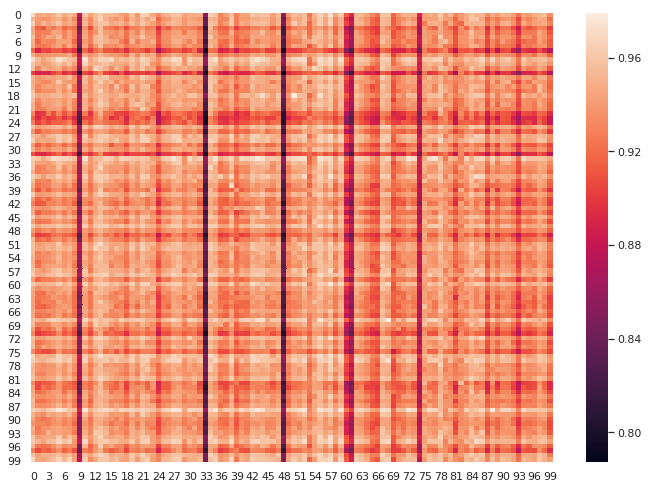

In [4]:

ckpt_path = "gs://kubeflow-rl-checkpoints/comparisons/cs-v7-lvslicenet-ts1-tcs1-tm1-exl1-ntm1/cs-v7-lvslicenet-ts1-tcs1-tm1-exl1-ntm1-j1026-1730-f4d7/output/model.ckpt-215387"

distances, embeddings = build_heatmap(iterator, model, ckpt_path)

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
ax = sns.heatmap(distances)



## Next steps
- Start a long run of the slicenet/exl1/ntm1/tm1/tcs1
- Improve the co-training problem - autoencoding instead of error-correcting, code as well as doc strings.
- Consider parameterizing whether encoder and decoders are variable scoped (separate networks).
- Build a mini index and perform some test searches.
- Experiment with a dense layer post-encoder instead of a reduce_mean to yield embedding vector.
- Propose retaining the \n characters in preprocessing step to enable richer embeddings and building AST's.
- Consider using larger networks than tiny.
- Why is the vocabulary only 8k in size??
